In [1]:
import torch
import torch.nn as nn
from strokes import StrokePatientsMIDataset, StrokePatientsMIProcessedDataset
from strokesdict import STROKEPATIENTSMI_LOCATION_DICT
from torcheeg.transforms import Select,BandSignal,Compose
from to import ToGrid, ToTensor
from downsample import SetSamplingRate
from baseline import BaselineCorrection

dataset = StrokePatientsMIDataset(root_path='./subdataset',
                                #   io_path='.torcheeg/datasets_1741248526955_4NJkc',
                        chunk_size=500,  # 1 second
                        overlap = 250,
                        offline_transform=Compose(
                                [BaselineCorrection(),
                                SetSamplingRate(origin_sampling_rate=500,target_sampling_rate=128),
                                BandSignal(sampling_rate=128,band_dict={'frequency_range':[8,40]})
                                ]),
                        online_transform=Compose(
                                [ToGrid(STROKEPATIENTSMI_LOCATION_DICT),ToTensor()]),
                        label_transform=Select('label'),
                        num_worker=8
)
print(dataset[0][0].shape) #EEG shape:torch.Size([1, 128, 9, 9])
print(dataset[0][1])  # label (int)
print(len(dataset))

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2025-03-12 11:13:38] INFO (torcheeg/MainThread) 🔍 | Processing EEG data. Processed EEG data has been cached to .torcheeg/datasets_1741749218647_FBfjc.
[2025-03-12 11:13:38] INFO (torcheeg/MainThread) ⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
[PROCESS]: 100%|██████████| 1/1 [00:00<00:00, 78.08it/s]

[RECORD ./subdataset/sourcedata/sub-46/sub-46_task-motor-imagery_eeg.mat]: 0it [00:00, ?it/s]
[RECORD ./subdataset/sourcedata/sub-46/sub-46_task-motor-imagery_eeg.mat]: 1it [00:00,  4.54it/s]
[RECORD ./subdataset/sourcedata/sub-46/sub-46_task-motor-imagery_eeg.mat]: 2it [00:00,  5.64it/s]
[RECORD ./subdataset/sourcedata/su

torch.Size([1, 128, 9, 9])
0
240


In [2]:
from eegswintransformer import SwinTransformer

HYPERPARAMETERS = {
    "seed": 42,
    "batch_size": 16,
    "lr": 1e-4,
    "weight_decay": 1e-4,
    "num_epochs": 50,
}
from torcheeg.model_selection import KFoldPerSubjectGroupbyTrial
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.utils.data import DataLoader
from classifier import ClassifierTrainer

k_fold = KFoldPerSubjectGroupbyTrial(
    n_splits=4,
    shuffle=True,
    random_state=42)

training_metrics = []
test_metrics = []

for i, (training_dataset, test_dataset) in enumerate(k_fold.split(dataset)):
    model = SwinTransformer(patch_size=(8,3,3),
                              num_classes=2,
                              depths=(2, 6, 4),
                              num_heads=(3,6,8),
                              window_size=(3,3,3),
                              in_chans=1
                              ) # T, W, H 同时缩小
    trainer = ClassifierTrainer(model=model,
                                num_classes=2,
                                lr=HYPERPARAMETERS['lr'],
                                weight_decay=HYPERPARAMETERS['weight_decay'],
                                metrics=["accuracy"],
                                accelerator="gpu")
    training_loader = DataLoader(training_dataset,
                             batch_size=HYPERPARAMETERS['batch_size'],
                             shuffle=True)
    test_loader = DataLoader(test_dataset,
                             batch_size=HYPERPARAMETERS['batch_size'],
                             shuffle=False)
    # 提前停止回调
    early_stopping_callback = EarlyStopping(
        monitor='train_loss',
        patience=20,
        mode='min',
        verbose=True
    )
    trainer.fit(training_loader,
                test_loader,
                max_epochs=HYPERPARAMETERS['num_epochs'],
                callbacks=[early_stopping_callback],
                # enable_progress_bar=True,
                enable_model_summary=False,
                limit_val_batches=0.0)
    training_result = trainer.test(training_loader,
                                   enable_progress_bar=True,
                                   enable_model_summary=True)[0]
    test_result = trainer.test(test_loader,
                               enable_progress_bar=True,
                               enable_model_summary=True)[0]
    training_metrics.append(training_result["test_accuracy"])
    test_metrics.append(test_result["test_accuracy"])
     

[2025-03-12 11:13:50] INFO (torcheeg/MainThread) 📊 | Create the split of train and test set.
[2025-03-12 11:13:50] INFO (torcheeg/MainThread) 😊 | Please set split_path to .torcheeg/model_selection_1741749230784_AwiNp for the next run, if you want to use the same setting for the experiment.
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarni

Epoch 0: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s, loss=1.52, train_loss=0.774, train_accuracy=0.562]

Metric train_loss improved. New best score: 0.774


Epoch 0: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s, loss=1.52, train_loss=0.774, train_accuracy=0.562]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-03-12 11:13:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.524 train_accuracy: 0.544 



Epoch 1: 100%|██████████| 10/10 [00:00<00:00, 18.12it/s, loss=1.03, train_loss=0.577, train_accuracy=0.812]

Metric train_loss improved by 0.197 >= min_delta = 0.0. New best score: 0.577


Epoch 1: 100%|██████████| 10/10 [00:00<00:00, 18.07it/s, loss=1.03, train_loss=0.577, train_accuracy=0.812]

[2025-03-12 11:13:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.533 train_accuracy: 0.731 



Epoch 2: 100%|██████████| 10/10 [00:00<00:00, 17.76it/s, loss=0.375, train_loss=0.0411, train_accuracy=1.000]

Metric train_loss improved by 0.536 >= min_delta = 0.0. New best score: 0.041


Epoch 2: 100%|██████████| 10/10 [00:00<00:00, 17.71it/s, loss=0.375, train_loss=0.0411, train_accuracy=1.000]

[2025-03-12 11:13:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.217 train_accuracy: 0.913 



Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 17.64it/s, loss=0.149, train_loss=0.0131, train_accuracy=1.000]

Metric train_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.013


Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 17.59it/s, loss=0.149, train_loss=0.0131, train_accuracy=1.000]

[2025-03-12 11:13:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.082 train_accuracy: 0.981 



Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 18.03it/s, loss=0.0509, train_loss=0.017, train_accuracy=1.000]  

[2025-03-12 11:13:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.020 train_accuracy: 1.000 



Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 17.88it/s, loss=0.0138, train_loss=0.00927, train_accuracy=1.000]

Metric train_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.009


Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 17.84it/s, loss=0.0138, train_loss=0.00927, train_accuracy=1.000]

[2025-03-12 11:13:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 6: 100%|██████████| 10/10 [00:00<00:00, 17.85it/s, loss=0.00559, train_loss=0.0136, train_accuracy=1.000] 

[2025-03-12 11:13:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 7: 100%|██████████| 10/10 [00:00<00:00, 17.85it/s, loss=0.0045, train_loss=0.000741, train_accuracy=1.000]

Metric train_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.001


Epoch 7: 100%|██████████| 10/10 [00:00<00:00, 17.80it/s, loss=0.0045, train_loss=0.000741, train_accuracy=1.000]

[2025-03-12 11:14:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 18.15it/s, loss=0.00328, train_loss=0.000462, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 18.10it/s, loss=0.00328, train_loss=0.000462, train_accuracy=1.000]

[2025-03-12 11:14:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 17.79it/s, loss=0.000969, train_loss=0.00224, train_accuracy=1.000] 

[2025-03-12 11:14:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 10: 100%|██████████| 10/10 [00:00<00:00, 17.78it/s, loss=0.000742, train_loss=0.000295, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 10/10 [00:00<00:00, 17.73it/s, loss=0.000742, train_loss=0.000295, train_accuracy=1.000]

[2025-03-12 11:14:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 11: 100%|██████████| 10/10 [00:00<00:00, 17.94it/s, loss=0.000818, train_loss=0.000691, train_accuracy=1.000]

[2025-03-12 11:14:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 12: 100%|██████████| 10/10 [00:00<00:00, 18.08it/s, loss=0.000851, train_loss=0.00103, train_accuracy=1.000] 

[2025-03-12 11:14:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 10/10 [00:00<00:00, 17.37it/s, loss=0.000519, train_loss=0.000598, train_accuracy=1.000]

[2025-03-12 11:14:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 10/10 [00:00<00:00, 17.33it/s, loss=0.000549, train_loss=9.43e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 10/10 [00:00<00:00, 17.28it/s, loss=0.000549, train_loss=9.43e-5, train_accuracy=1.000]

[2025-03-12 11:14:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 10/10 [00:00<00:00, 17.88it/s, loss=0.000693, train_loss=0.00107, train_accuracy=1.000]

[2025-03-12 11:14:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 10/10 [00:00<00:00, 17.45it/s, loss=0.000562, train_loss=0.000333, train_accuracy=1.000]

[2025-03-12 11:14:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 10/10 [00:00<00:00, 17.20it/s, loss=0.000285, train_loss=0.000202, train_accuracy=1.000]

[2025-03-12 11:14:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 10/10 [00:00<00:00, 17.48it/s, loss=0.000367, train_loss=0.00309, train_accuracy=1.000] 

[2025-03-12 11:14:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 10/10 [00:00<00:00, 17.46it/s, loss=0.000362, train_loss=0.000134, train_accuracy=1.000]

[2025-03-12 11:14:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 10/10 [00:00<00:00, 16.86it/s, loss=0.00031, train_loss=0.000221, train_accuracy=1.000] 

[2025-03-12 11:14:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 10/10 [00:00<00:00, 17.13it/s, loss=0.000383, train_loss=0.000281, train_accuracy=1.000]

[2025-03-12 11:14:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 10/10 [00:00<00:00, 17.32it/s, loss=0.000312, train_loss=0.000142, train_accuracy=1.000]

[2025-03-12 11:14:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 10/10 [00:00<00:00, 17.07it/s, loss=0.000253, train_loss=0.000314, train_accuracy=1.000]

[2025-03-12 11:14:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 10/10 [00:00<00:00, 17.25it/s, loss=0.000407, train_loss=0.000183, train_accuracy=1.000]

[2025-03-12 11:14:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 10/10 [00:00<00:00, 17.90it/s, loss=0.000525, train_loss=0.000101, train_accuracy=1.000]

[2025-03-12 11:14:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 10/10 [00:00<00:00, 17.60it/s, loss=0.000558, train_loss=0.00323, train_accuracy=1.000] 

[2025-03-12 11:14:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 10/10 [00:00<00:00, 18.06it/s, loss=0.000447, train_loss=0.000249, train_accuracy=1.000]

[2025-03-12 11:14:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 10/10 [00:00<00:00, 17.44it/s, loss=0.000237, train_loss=0.000123, train_accuracy=1.000]

[2025-03-12 11:14:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 10/10 [00:00<00:00, 18.08it/s, loss=0.000244, train_loss=0.000106, train_accuracy=1.000]

[2025-03-12 11:14:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 30: 100%|██████████| 10/10 [00:00<00:00, 17.84it/s, loss=0.000409, train_loss=0.0036, train_accuracy=1.000]  

[2025-03-12 11:14:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 10/10 [00:00<00:00, 17.52it/s, loss=0.00037, train_loss=0.00014, train_accuracy=1.000]  

[2025-03-12 11:14:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 10/10 [00:00<00:00, 17.99it/s, loss=0.000167, train_loss=0.000304, train_accuracy=1.000]

[2025-03-12 11:14:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 10/10 [00:00<00:00, 18.10it/s, loss=0.000262, train_loss=0.000178, train_accuracy=1.000]

[2025-03-12 11:14:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 10/10 [00:00<00:00, 17.81it/s, loss=0.000263, train_loss=0.000189, train_accuracy=1.000]

Monitored metric train_loss did not improve in the last 20 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 34: 100%|██████████| 10/10 [00:00<00:00, 17.75it/s, loss=0.000263, train_loss=0.000189, train_accuracy=1.000]

[2025-03-12 11:14:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 10/10 [00:00<00:00, 17.67it/s, loss=0.000263, train_loss=0.000189, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 61.23it/s]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-03-12 11:14:17] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 59.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss          7.701745198573917e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 62.84it/s]

[2025-03-12 11:14:17] INFO (torcheeg/MainThread) 
[Test] test_loss: 1.585 test_accuracy: 0.613 



Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 59.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.612500011920929
        test_loss           1.5846830606460571
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 16.97it/s, loss=1.83, train_loss=0.856, train_accuracy=0.312]

Metric train_loss improved. New best score: 0.856


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 16.93it/s, loss=1.83, train_loss=0.856, train_accuracy=0.312]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-03-12 11:14:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.825 train_accuracy: 0.475 



Epoch 1: 100%|██████████| 10/10 [00:00<00:00, 18.08it/s, loss=1.16, train_loss=0.198, train_accuracy=1.000]

Metric train_loss improved by 0.658 >= min_delta = 0.0. New best score: 0.198


Epoch 1: 100%|██████████| 10/10 [00:00<00:00, 18.03it/s, loss=1.16, train_loss=0.198, train_accuracy=1.000]

[2025-03-12 11:14:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.488 train_accuracy: 0.781 



Epoch 2: 100%|██████████| 10/10 [00:00<00:00, 18.11it/s, loss=0.35, train_loss=0.0943, train_accuracy=1.000]

Metric train_loss improved by 0.104 >= min_delta = 0.0. New best score: 0.094


Epoch 2: 100%|██████████| 10/10 [00:00<00:00, 18.06it/s, loss=0.35, train_loss=0.0943, train_accuracy=1.000]

[2025-03-12 11:14:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.211 train_accuracy: 0.931 



Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 17.99it/s, loss=0.147, train_loss=0.121, train_accuracy=0.938] 

[2025-03-12 11:14:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.083 train_accuracy: 0.981 



Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 17.18it/s, loss=0.0497, train_loss=0.00701, train_accuracy=1.000]

Metric train_loss improved by 0.087 >= min_delta = 0.0. New best score: 0.007


Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 17.14it/s, loss=0.0497, train_loss=0.00701, train_accuracy=1.000]

[2025-03-12 11:14:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.017 train_accuracy: 1.000 



Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 18.15it/s, loss=0.0124, train_loss=0.00929, train_accuracy=1.000]

[2025-03-12 11:14:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 6: 100%|██████████| 10/10 [00:00<00:00, 16.77it/s, loss=0.0081, train_loss=0.00168, train_accuracy=1.000] 

Metric train_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.002


Epoch 6: 100%|██████████| 10/10 [00:00<00:00, 16.72it/s, loss=0.0081, train_loss=0.00168, train_accuracy=1.000]

[2025-03-12 11:14:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 7: 100%|██████████| 10/10 [00:00<00:00, 17.36it/s, loss=0.00661, train_loss=0.018, train_accuracy=1.000]  

[2025-03-12 11:14:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 17.25it/s, loss=0.00395, train_loss=0.00415, train_accuracy=1.000]

[2025-03-12 11:14:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 17.64it/s, loss=0.00215, train_loss=0.00153, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 17.59it/s, loss=0.00215, train_loss=0.00153, train_accuracy=1.000]

[2025-03-12 11:14:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 10: 100%|██████████| 10/10 [00:00<00:00, 17.12it/s, loss=0.00134, train_loss=0.00131, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 10: 100%|██████████| 10/10 [00:00<00:00, 17.05it/s, loss=0.00134, train_loss=0.00131, train_accuracy=1.000]

[2025-03-12 11:14:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 11: 100%|██████████| 10/10 [00:00<00:00, 16.90it/s, loss=0.00125, train_loss=0.000466, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 10/10 [00:00<00:00, 16.85it/s, loss=0.00125, train_loss=0.000466, train_accuracy=1.000]

[2025-03-12 11:14:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 12: 100%|██████████| 10/10 [00:00<00:00, 17.25it/s, loss=0.000981, train_loss=0.000309, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 10/10 [00:00<00:00, 17.19it/s, loss=0.000981, train_loss=0.000309, train_accuracy=1.000]

[2025-03-12 11:14:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 10/10 [00:00<00:00, 16.99it/s, loss=0.000703, train_loss=0.00151, train_accuracy=1.000] 

[2025-03-12 11:14:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 10/10 [00:00<00:00, 16.98it/s, loss=0.00065, train_loss=0.000326, train_accuracy=1.000]

[2025-03-12 11:14:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 10/10 [00:00<00:00, 17.28it/s, loss=0.00105, train_loss=0.00472, train_accuracy=1.000] 

[2025-03-12 11:14:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 10/10 [00:00<00:00, 17.85it/s, loss=0.00112, train_loss=0.000571, train_accuracy=1.000]

[2025-03-12 11:14:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 10/10 [00:00<00:00, 17.49it/s, loss=0.000827, train_loss=0.00137, train_accuracy=1.000]

[2025-03-12 11:14:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 10/10 [00:00<00:00, 17.49it/s, loss=0.000618, train_loss=0.000288, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 10/10 [00:00<00:00, 17.43it/s, loss=0.000618, train_loss=0.000288, train_accuracy=1.000]

[2025-03-12 11:14:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 10/10 [00:00<00:00, 17.93it/s, loss=0.000339, train_loss=0.000258, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 10/10 [00:00<00:00, 17.88it/s, loss=0.000339, train_loss=0.000258, train_accuracy=1.000]

[2025-03-12 11:14:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 10/10 [00:00<00:00, 17.76it/s, loss=0.000519, train_loss=0.00021, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 10/10 [00:00<00:00, 17.71it/s, loss=0.000519, train_loss=0.00021, train_accuracy=1.000]

[2025-03-12 11:14:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 10/10 [00:00<00:00, 17.37it/s, loss=0.000594, train_loss=0.00202, train_accuracy=1.000] 

[2025-03-12 11:14:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 10/10 [00:00<00:00, 17.86it/s, loss=0.000405, train_loss=0.000416, train_accuracy=1.000]

[2025-03-12 11:14:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 10/10 [00:00<00:00, 17.69it/s, loss=0.000964, train_loss=0.00922, train_accuracy=1.000] 

[2025-03-12 11:14:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 10/10 [00:00<00:00, 17.42it/s, loss=0.00186, train_loss=0.000157, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 10/10 [00:00<00:00, 17.37it/s, loss=0.00186, train_loss=0.000157, train_accuracy=1.000]

[2025-03-12 11:14:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 10/10 [00:00<00:00, 17.80it/s, loss=0.00127, train_loss=0.000227, train_accuracy=1.000]

[2025-03-12 11:14:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 10/10 [00:00<00:00, 17.87it/s, loss=0.000376, train_loss=0.000288, train_accuracy=1.000]

[2025-03-12 11:14:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 10/10 [00:00<00:00, 17.77it/s, loss=0.00059, train_loss=0.000121, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 10/10 [00:00<00:00, 17.72it/s, loss=0.00059, train_loss=0.000121, train_accuracy=1.000]

[2025-03-12 11:14:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 10/10 [00:00<00:00, 17.77it/s, loss=0.000592, train_loss=0.000264, train_accuracy=1.000]

[2025-03-12 11:14:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 10/10 [00:00<00:00, 17.59it/s, loss=0.000564, train_loss=0.00114, train_accuracy=1.000] 

[2025-03-12 11:14:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 30: 100%|██████████| 10/10 [00:00<00:00, 17.69it/s, loss=0.000509, train_loss=0.000608, train_accuracy=1.000]

[2025-03-12 11:14:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 10/10 [00:00<00:00, 17.11it/s, loss=0.000256, train_loss=0.00014, train_accuracy=1.000] 

[2025-03-12 11:14:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 10/10 [00:00<00:00, 17.46it/s, loss=0.000358, train_loss=0.000157, train_accuracy=1.000]

[2025-03-12 11:14:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 10/10 [00:00<00:00, 17.54it/s, loss=0.000315, train_loss=0.000117, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 10/10 [00:00<00:00, 17.49it/s, loss=0.000315, train_loss=0.000117, train_accuracy=1.000]

[2025-03-12 11:14:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 10/10 [00:00<00:00, 17.34it/s, loss=0.00026, train_loss=0.00174, train_accuracy=1.000]  

[2025-03-12 11:14:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 35: 100%|██████████| 10/10 [00:00<00:00, 17.23it/s, loss=0.000345, train_loss=0.000857, train_accuracy=1.000]

[2025-03-12 11:14:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 36: 100%|██████████| 10/10 [00:00<00:00, 18.09it/s, loss=0.000276, train_loss=2.66e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 10/10 [00:00<00:00, 18.04it/s, loss=0.000276, train_loss=2.66e-5, train_accuracy=1.000]

[2025-03-12 11:14:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 10/10 [00:00<00:00, 17.81it/s, loss=0.000228, train_loss=0.000154, train_accuracy=1.000]

[2025-03-12 11:14:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 10/10 [00:00<00:00, 17.56it/s, loss=0.000356, train_loss=0.000129, train_accuracy=1.000]

[2025-03-12 11:14:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 10/10 [00:00<00:00, 18.04it/s, loss=0.000347, train_loss=9.82e-5, train_accuracy=1.000] 

[2025-03-12 11:14:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 10/10 [00:00<00:00, 18.08it/s, loss=0.000196, train_loss=7.78e-5, train_accuracy=1.000] 

[2025-03-12 11:14:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 41: 100%|██████████| 10/10 [00:00<00:00, 17.47it/s, loss=0.000278, train_loss=9.95e-5, train_accuracy=1.000]

[2025-03-12 11:14:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 10/10 [00:00<00:00, 17.20it/s, loss=0.000974, train_loss=8.45e-5, train_accuracy=1.000] 

[2025-03-12 11:14:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 43: 100%|██████████| 10/10 [00:00<00:00, 18.13it/s, loss=0.000968, train_loss=0.000262, train_accuracy=1.000]

[2025-03-12 11:14:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 10/10 [00:00<00:00, 17.77it/s, loss=0.000321, train_loss=8.56e-5, train_accuracy=1.000] 

[2025-03-12 11:14:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 45: 100%|██████████| 10/10 [00:00<00:00, 17.91it/s, loss=0.000549, train_loss=0.00112, train_accuracy=1.000] 

[2025-03-12 11:14:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 46: 100%|██████████| 10/10 [00:00<00:00, 18.02it/s, loss=0.000539, train_loss=0.000188, train_accuracy=1.000]

[2025-03-12 11:14:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 47: 100%|██████████| 10/10 [00:00<00:00, 17.60it/s, loss=0.000217, train_loss=0.000242, train_accuracy=1.000]

[2025-03-12 11:14:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 10/10 [00:00<00:00, 17.85it/s, loss=0.000193, train_loss=0.000131, train_accuracy=1.000]

[2025-03-12 11:14:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 49: 100%|██████████| 10/10 [00:00<00:00, 17.60it/s, loss=0.000187, train_loss=8.06e-5, train_accuracy=1.000] 

[2025-03-12 11:14:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 10/10 [00:00<00:00, 17.51it/s, loss=0.000187, train_loss=8.06e-5, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 64.53it/s]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-03-12 11:14:49] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 62.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss         4.1412895370740443e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 62.27it/s]

[2025-03-12 11:14:50] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.965 test_accuracy: 0.788 



Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 59.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.7875000238418579
        test_loss           0.9648844003677368
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 15.93it/s, loss=1.73, train_loss=0.846, train_accuracy=0.625]

Metric train_loss improved. New best score: 0.846


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 15.90it/s, loss=1.73, train_loss=0.846, train_accuracy=0.625]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-03-12 11:14:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.725 train_accuracy: 0.470 



Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 17.93it/s, loss=0.944, train_loss=0.794, train_accuracy=0.625]

Metric train_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.794


Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 17.89it/s, loss=0.944, train_loss=0.794, train_accuracy=0.625]

[2025-03-12 11:14:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.719 train_accuracy: 0.710 



Epoch 2: 100%|██████████| 13/13 [00:00<00:00, 18.10it/s, loss=0.424, train_loss=0.145, train_accuracy=1.000]

Metric train_loss improved by 0.649 >= min_delta = 0.0. New best score: 0.145


Epoch 2: 100%|██████████| 13/13 [00:00<00:00, 18.06it/s, loss=0.424, train_loss=0.145, train_accuracy=1.000]

[2025-03-12 11:14:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.291 train_accuracy: 0.900 



Epoch 3: 100%|██████████| 13/13 [00:00<00:00, 18.16it/s, loss=0.185, train_loss=0.0954, train_accuracy=1.000]

Metric train_loss improved by 0.050 >= min_delta = 0.0. New best score: 0.095


Epoch 3: 100%|██████████| 13/13 [00:00<00:00, 18.12it/s, loss=0.185, train_loss=0.0954, train_accuracy=1.000]

[2025-03-12 11:14:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.132 train_accuracy: 0.965 



Epoch 4: 100%|██████████| 13/13 [00:00<00:00, 17.81it/s, loss=0.0761, train_loss=0.046, train_accuracy=1.000] 

Metric train_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.046


Epoch 4: 100%|██████████| 13/13 [00:00<00:00, 17.77it/s, loss=0.0761, train_loss=0.046, train_accuracy=1.000]

[2025-03-12 11:14:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.049 train_accuracy: 0.995 



Epoch 5: 100%|██████████| 13/13 [00:00<00:00, 18.22it/s, loss=0.025, train_loss=0.00497, train_accuracy=1.000] 

Metric train_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.005


Epoch 5: 100%|██████████| 13/13 [00:00<00:00, 18.18it/s, loss=0.025, train_loss=0.00497, train_accuracy=1.000]

[2025-03-12 11:14:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.012 train_accuracy: 1.000 



Epoch 6: 100%|██████████| 13/13 [00:00<00:00, 18.20it/s, loss=0.00934, train_loss=0.00241, train_accuracy=1.000]

Metric train_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.002


Epoch 6: 100%|██████████| 13/13 [00:00<00:00, 18.16it/s, loss=0.00934, train_loss=0.00241, train_accuracy=1.000]

[2025-03-12 11:14:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 7: 100%|██████████| 13/13 [00:00<00:00, 17.89it/s, loss=0.00342, train_loss=0.0015, train_accuracy=1.000]  

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 7: 100%|██████████| 13/13 [00:00<00:00, 17.85it/s, loss=0.00342, train_loss=0.0015, train_accuracy=1.000]

[2025-03-12 11:14:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 8: 100%|██████████| 13/13 [00:00<00:00, 18.18it/s, loss=0.00195, train_loss=0.00139, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 8: 100%|██████████| 13/13 [00:00<00:00, 18.15it/s, loss=0.00195, train_loss=0.00139, train_accuracy=1.000]

[2025-03-12 11:14:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 9: 100%|██████████| 13/13 [00:00<00:00, 18.14it/s, loss=0.00194, train_loss=0.00126, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 9: 100%|██████████| 13/13 [00:00<00:00, 18.11it/s, loss=0.00194, train_loss=0.00126, train_accuracy=1.000]

[2025-03-12 11:14:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 10: 100%|██████████| 13/13 [00:00<00:00, 17.80it/s, loss=0.00194, train_loss=0.000223, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 13/13 [00:00<00:00, 17.77it/s, loss=0.00194, train_loss=0.000223, train_accuracy=1.000]

[2025-03-12 11:15:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 11: 100%|██████████| 13/13 [00:00<00:00, 17.91it/s, loss=0.00156, train_loss=0.00126, train_accuracy=1.000] 

[2025-03-12 11:15:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 12: 100%|██████████| 13/13 [00:00<00:00, 18.10it/s, loss=0.00136, train_loss=0.000349, train_accuracy=1.000]

[2025-03-12 11:15:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 13/13 [00:00<00:00, 17.84it/s, loss=0.000826, train_loss=0.000271, train_accuracy=1.000]

[2025-03-12 11:15:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 13/13 [00:00<00:00, 17.94it/s, loss=0.000921, train_loss=0.00538, train_accuracy=1.000] 

[2025-03-12 11:15:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 13/13 [00:00<00:00, 17.65it/s, loss=0.0021, train_loss=0.0249, train_accuracy=1.000]    

[2025-03-12 11:15:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 13/13 [00:00<00:00, 18.00it/s, loss=0.00181, train_loss=0.00251, train_accuracy=1.000] 

[2025-03-12 11:15:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 13/13 [00:00<00:00, 18.07it/s, loss=0.00343, train_loss=0.00413, train_accuracy=1.000] 

[2025-03-12 11:15:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 13/13 [00:00<00:00, 17.87it/s, loss=0.00293, train_loss=0.00151, train_accuracy=1.000] 

[2025-03-12 11:15:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 13/13 [00:00<00:00, 17.58it/s, loss=0.00242, train_loss=0.00234, train_accuracy=1.000] 

[2025-03-12 11:15:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 13/13 [00:00<00:00, 18.13it/s, loss=0.00197, train_loss=0.000408, train_accuracy=1.000]

[2025-03-12 11:15:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 13/13 [00:00<00:00, 17.65it/s, loss=0.00136, train_loss=0.0002, train_accuracy=1.000]  

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 13/13 [00:00<00:00, 17.62it/s, loss=0.00136, train_loss=0.0002, train_accuracy=1.000]

[2025-03-12 11:15:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 13/13 [00:00<00:00, 17.92it/s, loss=0.00125, train_loss=0.00219, train_accuracy=1.000]

[2025-03-12 11:15:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 13/13 [00:00<00:00, 17.92it/s, loss=0.000792, train_loss=0.00013, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 13/13 [00:00<00:00, 17.88it/s, loss=0.000792, train_loss=0.00013, train_accuracy=1.000]

[2025-03-12 11:15:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 13/13 [00:00<00:00, 17.98it/s, loss=0.000482, train_loss=3.39e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 13/13 [00:00<00:00, 17.95it/s, loss=0.000482, train_loss=3.39e-5, train_accuracy=1.000]

[2025-03-12 11:15:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 13/13 [00:00<00:00, 18.08it/s, loss=0.000177, train_loss=8.86e-5, train_accuracy=1.000] 

[2025-03-12 11:15:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 13/13 [00:00<00:00, 17.76it/s, loss=0.000112, train_loss=1.62e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 13/13 [00:00<00:00, 17.73it/s, loss=0.000112, train_loss=1.62e-5, train_accuracy=1.000]

[2025-03-12 11:15:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 13/13 [00:00<00:00, 17.33it/s, loss=0.000953, train_loss=0.000316, train_accuracy=1.000]

[2025-03-12 11:15:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 13/13 [00:00<00:00, 17.25it/s, loss=0.000928, train_loss=3.5e-5, train_accuracy=1.000]  

[2025-03-12 11:15:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 13/13 [00:00<00:00, 17.31it/s, loss=0.00127, train_loss=0.000251, train_accuracy=1.000]

[2025-03-12 11:15:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 30: 100%|██████████| 13/13 [00:00<00:00, 17.52it/s, loss=0.000818, train_loss=0.00119, train_accuracy=1.000]

[2025-03-12 11:15:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 13/13 [00:00<00:00, 17.43it/s, loss=0.000426, train_loss=8.18e-5, train_accuracy=1.000] 

[2025-03-12 11:15:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 13/13 [00:00<00:00, 17.83it/s, loss=0.00021, train_loss=6.75e-5, train_accuracy=1.000]  

[2025-03-12 11:15:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 13/13 [00:00<00:00, 17.53it/s, loss=0.00015, train_loss=0.000138, train_accuracy=1.000] 

[2025-03-12 11:15:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 13/13 [00:00<00:00, 17.79it/s, loss=0.000112, train_loss=9.43e-6, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 13/13 [00:00<00:00, 17.76it/s, loss=0.000112, train_loss=9.43e-6, train_accuracy=1.000]

[2025-03-12 11:15:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 35: 100%|██████████| 13/13 [00:00<00:00, 18.03it/s, loss=0.000115, train_loss=8.15e-5, train_accuracy=1.000] 

[2025-03-12 11:15:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 36: 100%|██████████| 13/13 [00:00<00:00, 18.01it/s, loss=0.000361, train_loss=1.15e-5, train_accuracy=1.000] 

[2025-03-12 11:15:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 13/13 [00:00<00:00, 17.72it/s, loss=0.000101, train_loss=2.25e-5, train_accuracy=1.000] 

[2025-03-12 11:15:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 13/13 [00:00<00:00, 17.53it/s, loss=0.00138, train_loss=7.31e-5, train_accuracy=1.000] 

[2025-03-12 11:15:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 13/13 [00:00<00:00, 17.75it/s, loss=0.00124, train_loss=6.7e-5, train_accuracy=1.000]  

[2025-03-12 11:15:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 13/13 [00:00<00:00, 17.52it/s, loss=0.00191, train_loss=0.0327, train_accuracy=1.000]   

[2025-03-12 11:15:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 41: 100%|██████████| 13/13 [00:00<00:00, 17.38it/s, loss=0.0248, train_loss=0.00226, train_accuracy=1.000]  

[2025-03-12 11:15:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.035 train_accuracy: 0.995 



Epoch 42: 100%|██████████| 13/13 [00:00<00:00, 17.83it/s, loss=0.41, train_loss=1.250, train_accuracy=0.625]    

[2025-03-12 11:15:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.595 train_accuracy: 0.825 



Epoch 43: 100%|██████████| 13/13 [00:00<00:00, 17.49it/s, loss=0.757, train_loss=0.941, train_accuracy=0.750]

[2025-03-12 11:15:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.844 train_accuracy: 0.715 



Epoch 44: 100%|██████████| 13/13 [00:00<00:00, 17.69it/s, loss=0.523, train_loss=0.0531, train_accuracy=1.000]

[2025-03-12 11:15:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.299 train_accuracy: 0.860 



Epoch 45: 100%|██████████| 13/13 [00:00<00:00, 17.89it/s, loss=0.147, train_loss=0.0121, train_accuracy=1.000]

[2025-03-12 11:15:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.075 train_accuracy: 0.985 



Epoch 46: 100%|██████████| 13/13 [00:00<00:00, 18.15it/s, loss=0.0316, train_loss=0.00305, train_accuracy=1.000]

[2025-03-12 11:15:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.015 train_accuracy: 0.995 



Epoch 47: 100%|██████████| 13/13 [00:00<00:00, 18.11it/s, loss=0.0117, train_loss=0.00126, train_accuracy=1.000]

[2025-03-12 11:15:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 0.995 



Epoch 48: 100%|██████████| 13/13 [00:00<00:00, 17.89it/s, loss=0.00807, train_loss=0.00187, train_accuracy=1.000]

[2025-03-12 11:15:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 49: 100%|██████████| 13/13 [00:00<00:00, 18.17it/s, loss=0.00246, train_loss=0.00154, train_accuracy=1.000]

[2025-03-12 11:15:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 13/13 [00:00<00:00, 18.09it/s, loss=0.00246, train_loss=0.00154, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 64.62it/s]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-03-12 11:15:30] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 62.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss          0.0003725667775142938
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 71.53it/s]

[2025-03-12 11:15:31] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.343 test_accuracy: 0.925 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 65.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.925000011920929
        test_loss           0.34308409690856934
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 17.66it/s, loss=1.83, train_loss=0.855, train_accuracy=0.250]

Metric train_loss improved. New best score: 0.855


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 17.63it/s, loss=1.83, train_loss=0.855, train_accuracy=0.250]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-03-12 11:15:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.828 train_accuracy: 0.435 



Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 17.93it/s, loss=0.732, train_loss=0.371, train_accuracy=0.875]

Metric train_loss improved by 0.484 >= min_delta = 0.0. New best score: 0.371


Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 17.89it/s, loss=0.732, train_loss=0.371, train_accuracy=0.875]

[2025-03-12 11:15:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.615 train_accuracy: 0.715 



Epoch 2: 100%|██████████| 13/13 [00:00<00:00, 18.06it/s, loss=0.403, train_loss=0.310, train_accuracy=0.875]

Metric train_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.310


Epoch 2: 100%|██████████| 13/13 [00:00<00:00, 18.02it/s, loss=0.403, train_loss=0.310, train_accuracy=0.875]

[2025-03-12 11:15:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.287 train_accuracy: 0.915 



Epoch 3: 100%|██████████| 13/13 [00:00<00:00, 17.94it/s, loss=0.212, train_loss=0.103, train_accuracy=1.000] 

Metric train_loss improved by 0.207 >= min_delta = 0.0. New best score: 0.103


Epoch 3: 100%|██████████| 13/13 [00:00<00:00, 17.90it/s, loss=0.212, train_loss=0.103, train_accuracy=1.000]

[2025-03-12 11:15:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.168 train_accuracy: 0.930 



Epoch 4: 100%|██████████| 13/13 [00:00<00:00, 17.76it/s, loss=0.082, train_loss=0.00308, train_accuracy=1.000]

Metric train_loss improved by 0.100 >= min_delta = 0.0. New best score: 0.003


Epoch 4: 100%|██████████| 13/13 [00:00<00:00, 17.72it/s, loss=0.082, train_loss=0.00308, train_accuracy=1.000]

[2025-03-12 11:15:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.047 train_accuracy: 0.995 



Epoch 5: 100%|██████████| 13/13 [00:00<00:00, 17.83it/s, loss=0.0294, train_loss=0.00778, train_accuracy=1.000]

[2025-03-12 11:15:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.020 train_accuracy: 1.000 



Epoch 6: 100%|██████████| 13/13 [00:00<00:00, 17.52it/s, loss=0.0146, train_loss=0.000303, train_accuracy=1.000]

Metric train_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 13/13 [00:00<00:00, 17.48it/s, loss=0.0146, train_loss=0.000303, train_accuracy=1.000]

[2025-03-12 11:15:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.015 train_accuracy: 1.000 



Epoch 7: 100%|██████████| 13/13 [00:00<00:00, 17.74it/s, loss=0.00678, train_loss=0.00175, train_accuracy=1.000]

[2025-03-12 11:15:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 8: 100%|██████████| 13/13 [00:00<00:00, 18.16it/s, loss=0.00265, train_loss=0.000782, train_accuracy=1.000]

[2025-03-12 11:15:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 9: 100%|██████████| 13/13 [00:00<00:00, 17.79it/s, loss=0.00221, train_loss=0.000655, train_accuracy=1.000]

[2025-03-12 11:15:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 10: 100%|██████████| 13/13 [00:00<00:00, 18.07it/s, loss=0.00228, train_loss=0.000356, train_accuracy=1.000]

[2025-03-12 11:15:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 11: 100%|██████████| 13/13 [00:00<00:00, 18.18it/s, loss=0.00181, train_loss=0.000974, train_accuracy=1.000]

[2025-03-12 11:15:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 12: 100%|██████████| 13/13 [00:00<00:00, 17.94it/s, loss=0.000721, train_loss=0.00043, train_accuracy=1.000] 

[2025-03-12 11:15:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 13/13 [00:00<00:00, 17.75it/s, loss=0.000606, train_loss=0.000446, train_accuracy=1.000]

[2025-03-12 11:15:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 13/13 [00:00<00:00, 17.65it/s, loss=0.000301, train_loss=0.000142, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 13/13 [00:00<00:00, 17.61it/s, loss=0.000301, train_loss=0.000142, train_accuracy=1.000]

[2025-03-12 11:15:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 13/13 [00:00<00:00, 17.88it/s, loss=0.000233, train_loss=0.000204, train_accuracy=1.000]

[2025-03-12 11:15:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 13/13 [00:00<00:00, 18.08it/s, loss=0.000423, train_loss=0.000493, train_accuracy=1.000]

[2025-03-12 11:15:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 13/13 [00:00<00:00, 18.00it/s, loss=0.000319, train_loss=8.02e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 13/13 [00:00<00:00, 17.96it/s, loss=0.000319, train_loss=8.02e-5, train_accuracy=1.000]

[2025-03-12 11:15:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 13/13 [00:00<00:00, 18.00it/s, loss=0.000268, train_loss=0.000119, train_accuracy=1.000]

[2025-03-12 11:15:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 13/13 [00:00<00:00, 18.16it/s, loss=0.000451, train_loss=0.000484, train_accuracy=1.000]

[2025-03-12 11:15:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 13/13 [00:00<00:00, 17.88it/s, loss=0.000335, train_loss=0.00165, train_accuracy=1.000] 

[2025-03-12 11:15:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 13/13 [00:00<00:00, 18.16it/s, loss=0.000915, train_loss=0.00129, train_accuracy=1.000] 

[2025-03-12 11:15:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 13/13 [00:00<00:00, 18.12it/s, loss=0.00088, train_loss=0.000187, train_accuracy=1.000] 

[2025-03-12 11:15:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 13/13 [00:00<00:00, 17.56it/s, loss=0.000345, train_loss=0.000381, train_accuracy=1.000]

[2025-03-12 11:15:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 13/13 [00:00<00:00, 18.17it/s, loss=0.000315, train_loss=0.00025, train_accuracy=1.000] 

[2025-03-12 11:15:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 13/13 [00:00<00:00, 18.18it/s, loss=0.00024, train_loss=0.000435, train_accuracy=1.000] 

[2025-03-12 11:15:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 13/13 [00:00<00:00, 17.77it/s, loss=0.000271, train_loss=0.000113, train_accuracy=1.000]

[2025-03-12 11:15:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 13/13 [00:00<00:00, 18.20it/s, loss=0.000292, train_loss=4.87e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 13/13 [00:00<00:00, 18.17it/s, loss=0.000292, train_loss=4.87e-5, train_accuracy=1.000]

[2025-03-12 11:15:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 13/13 [00:00<00:00, 17.99it/s, loss=0.000369, train_loss=0.00238, train_accuracy=1.000] 

[2025-03-12 11:15:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 13/13 [00:00<00:00, 17.71it/s, loss=0.000267, train_loss=6.03e-5, train_accuracy=1.000] 

[2025-03-12 11:15:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 30: 100%|██████████| 13/13 [00:00<00:00, 18.18it/s, loss=0.000672, train_loss=0.000529, train_accuracy=1.000]

[2025-03-12 11:15:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 13/13 [00:00<00:00, 17.84it/s, loss=0.00026, train_loss=0.000851, train_accuracy=1.000] 

[2025-03-12 11:15:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 13/13 [00:00<00:00, 18.14it/s, loss=0.000195, train_loss=4.27e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 13/13 [00:00<00:00, 18.10it/s, loss=0.000195, train_loss=4.27e-5, train_accuracy=1.000]

[2025-03-12 11:15:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 13/13 [00:00<00:00, 18.19it/s, loss=0.000147, train_loss=2.38e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 13/13 [00:00<00:00, 18.15it/s, loss=0.000147, train_loss=2.38e-5, train_accuracy=1.000]

[2025-03-12 11:15:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 13/13 [00:00<00:00, 17.98it/s, loss=0.000247, train_loss=8.15e-5, train_accuracy=1.000] 

[2025-03-12 11:15:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 35: 100%|██████████| 13/13 [00:00<00:00, 18.21it/s, loss=0.000614, train_loss=3.52e-5, train_accuracy=1.000]

[2025-03-12 11:15:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 36: 100%|██████████| 13/13 [00:00<00:00, 18.19it/s, loss=0.000554, train_loss=0.000291, train_accuracy=1.000]

[2025-03-12 11:15:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 13/13 [00:00<00:00, 17.95it/s, loss=0.000874, train_loss=0.000104, train_accuracy=1.000]

[2025-03-12 11:16:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 13/13 [00:00<00:00, 18.04it/s, loss=0.000723, train_loss=0.0003, train_accuracy=1.000]  

[2025-03-12 11:16:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 13/13 [00:00<00:00, 18.10it/s, loss=0.000495, train_loss=0.00362, train_accuracy=1.000]

[2025-03-12 11:16:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 13/13 [00:00<00:00, 17.83it/s, loss=0.000328, train_loss=1.59e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 13/13 [00:00<00:00, 17.79it/s, loss=0.000328, train_loss=1.59e-5, train_accuracy=1.000]

[2025-03-12 11:16:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 41: 100%|██████████| 13/13 [00:00<00:00, 18.04it/s, loss=0.00013, train_loss=0.000541, train_accuracy=1.000] 

[2025-03-12 11:16:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 13/13 [00:00<00:00, 17.75it/s, loss=0.000543, train_loss=0.000165, train_accuracy=1.000]

[2025-03-12 11:16:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 43: 100%|██████████| 13/13 [00:00<00:00, 18.13it/s, loss=0.000438, train_loss=0.000173, train_accuracy=1.000]

[2025-03-12 11:16:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 13/13 [00:00<00:00, 18.07it/s, loss=0.000131, train_loss=7.87e-6, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 13/13 [00:00<00:00, 18.03it/s, loss=0.000131, train_loss=7.87e-6, train_accuracy=1.000]

[2025-03-12 11:16:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 45: 100%|██████████| 13/13 [00:00<00:00, 17.83it/s, loss=0.000247, train_loss=9.12e-5, train_accuracy=1.000] 

[2025-03-12 11:16:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 46: 100%|██████████| 13/13 [00:00<00:00, 18.03it/s, loss=0.000406, train_loss=7.87e-6, train_accuracy=1.000]

[2025-03-12 11:16:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 47: 100%|██████████| 13/13 [00:00<00:00, 17.94it/s, loss=0.00109, train_loss=0.000588, train_accuracy=1.000]

[2025-03-12 11:16:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 13/13 [00:00<00:00, 17.85it/s, loss=0.00753, train_loss=0.0366, train_accuracy=1.000]  

[2025-03-12 11:16:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.011 train_accuracy: 1.000 



Epoch 49: 100%|██████████| 13/13 [00:00<00:00, 17.71it/s, loss=0.287, train_loss=0.348, train_accuracy=0.875]   

[2025-03-12 11:16:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.434 train_accuracy: 0.890 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 13/13 [00:00<00:00, 17.64it/s, loss=0.287, train_loss=0.348, train_accuracy=0.875]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 61.02it/s]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-03-12 11:16:10] INFO (torcheeg/MainThread) 
[Test] test_loss: 1.021 test_accuracy: 0.750 



Testing DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 59.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                0.75
        test_loss           1.0206117630004883
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 71.88it/s]

[2025-03-12 11:16:11] INFO (torcheeg/MainThread) 
[Test] test_loss: 1.782 test_accuracy: 0.675 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 65.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.675000011920929
        test_loss            1.782491683959961
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [3]:
for i in range(0, len(test_metrics), 4):
    print(f"{i}\t"
          f"{np.mean(training_metrics[i:i+4]):.3f}\t"
          f"{np.std(training_metrics[i:i+4]):.3f}\t"
          f"{np.mean(test_metrics[i:i+4]):.3f}\t"
          f"{np.std(test_metrics[i:i+4]):.3f}")


0	1.000	0.000	0.844	0.108


In [4]:
for i in range(0, len(test_metrics), 4):
    print(i,np.mean(training_metrics[i:i+4]), np.std(training_metrics[i:i+4]),np.mean(test_metrics[i:i+4]), np.std(test_metrics[i:i+4]))

0 1.0 0.0 0.8437500149011612 0.10807260584116332


In [5]:
for i, score in enumerate(test_metrics):
    print(f"{score:.3f}", end="\t")
    if (i + 1) % 4 == 0:
        print()  # Print a newline every 4 elements

# Ensure the last line is printed properly if the length isn't a multiple of 4
if len(test_metrics) % 4 != 0:
    print()


0.675	0.850	0.875	0.975	


In [21]:
eeg = dataset[0][0]
print(eeg.shape)

torch.Size([1, 128, 9, 9])


In [22]:
channel = eeg[:,:,2,5]
print(channel.shape)

torch.Size([1, 128])


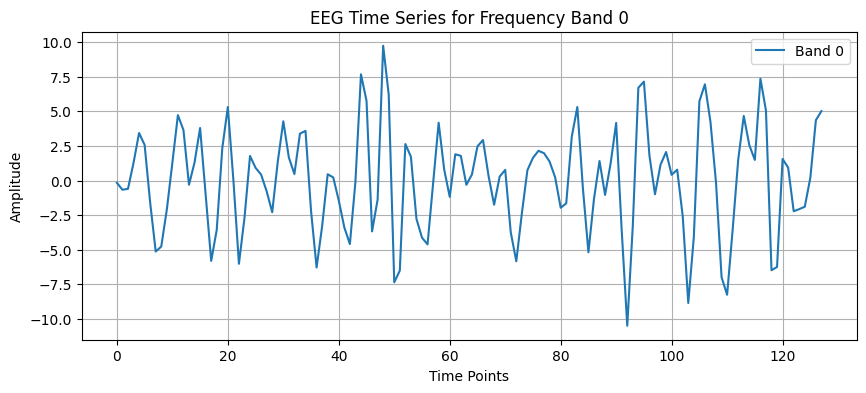

In [23]:
import matplotlib.pyplot as plt

# 假设 `eeg` 是 (4, 128) 形状的 EEG 频带数据
eeg = channel

# 选择第一个频带 (索引 0)
band_idx = 0
eeg_band = eeg[band_idx]  # 形状变为 (128,)

# 绘制折线图
plt.figure(figsize=(10, 4))
plt.plot(eeg_band, label=f'Band {band_idx}')
plt.xlabel("Time Points")
plt.ylabel("Amplitude")
plt.title(f"EEG Time Series for Frequency Band {band_idx}")
plt.legend()
plt.grid()
plt.show()
